https://github.com/OctThe16th/PPO-Keras

https://github.com/hill-a/stable-baselines

https://github.com/rlcode/reinforcement-learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model, clone_model
from keras.optimizers import Adam
from keras import backend as K 

Using TensorFlow backend.


In [2]:
class Environment:
    def __init__(self, verbose=False):
        self.n_actions = 3
        self.n_obs = 2
        self.verbose = verbose
        self.space = np.sin(np.linspace(0,2*np.pi,20))
        
    def reset(self):
        self.x = 0
        self.target = self.space[self.x]
        self.agent = self.space[self.x]
        self.state = [self.target, self.agent]
        
        self.x_data = []
        self.target_data = []
        self.agent_data = []
        return np.array(self.state)
    
    def step(self, action):
        self.x += 1
        self.target = self.space[self.x]
        if action == 0:
            pass
        if action == 1:
            self.agent += 0.25
        if action == 2:
            self.agent -= 0.25
            
        self.state = [self.target, self.agent]
        
        dist = abs(self.target - self.agent)
        reward = 0
        if dist < 0.25:
            reward = 1.
        if dist > 0.5:
            reward = -1.
            
        done = False
        if self.x >= 19:
            done = True
            
        self.x_data.append(self.x)
        self.target_data.append(self.target)
        self.agent_data.append(self.agent)
            
        return np.array(self.state), reward, done, {}
    
    def get_render_data(self):
        return self.x_data, self.target_data, self.agent_data
    
    def render(self):
        plt.plot(self.x_data, self.target_data, '.')
        plt.plot(self.x_data, self.agent_data, '.')
        plt.show()

In [3]:
class Agent:
    def __init__(self, n_obs, n_actions, ppo=True, verbose=False):
        K.clear_session()
        self.ppo = ppo
        self.n_obs = n_obs
        self.n_actions = n_actions
        self.iter = 0
        self.verbose = verbose
        
        self.discount_factor = 0.99
        self.epsilon = 0.2
        self.entropy_loss = 1e-3
        self.actor_lr = 0.001
        self.critic_lr = 0.005
        self.hidden_size = 128
        
        self.actor = self.build_actor() 
        self.critic = self.build_critic()

    def proximal_policy_optimization_loss(self, advantage, old_prediction):
        def loss(y_true, y_pred):
            prob = y_true * y_pred
            old_prob = y_true * old_prediction
            r = prob/(old_prob + 1e-10)
            return -K.mean(
                K.minimum(
                    r * advantage, 
                    K.clip(r, min_value=1 - self.epsilon, max_value=1 + self.epsilon) * advantage
                ) + self.entropy_loss * (prob * K.log(prob + 1e-10)))
        return loss
    
    def build_actor(self):
        state_inputs = Input(shape=(self.n_obs,))
        advantage = Input(shape=(1,))
        old_prediction = Input(shape=(self.n_actions,))
        
        x = Dense(self.hidden_size, activation='relu')(state_inputs)
        x = Dense(self.hidden_size, activation='relu')(x)
        out_actions = Dense(self.n_actions, activation='softmax')(x)

        model = Model(inputs=[state_inputs, advantage, old_prediction],
                      outputs=[out_actions])
        
        model.compile(optimizer=Adam(lr=self.actor_lr),
                      loss=[self.proximal_policy_optimization_loss(
                          advantage=advantage,
                          old_prediction=old_prediction)])
        return model
    
    def build_critic(self):
        state_inputs = Input(shape=(self.n_obs,))
        x = Dense(self.hidden_size, activation='relu')(state_inputs)
        x = Dense(self.hidden_size, activation='relu')(x)
        predictions = Dense(1, activation='linear')(x)

        model = Model(inputs=state_inputs, outputs=predictions)
        model.compile(optimizer=Adam(lr=self.critic_lr),
                      loss='mse')
        return model
    
    def get_action(self, observation):
        # Predict the probability destribution of the actions as a vactor
        prob = self.actor.predict([observation.reshape(1,self.n_obs), DUMMY_VALUE, DUMMY_ACTION])
        prob = prob.flatten()
        
        # Sample an action as a scaler
        action = np.random.choice(self.n_actions, 1, p=prob)[0]
        
        # Vectorize the action as a one-hot encoding
        action_vector = np.zeros(self.n_actions)
        action_vector[action] = 1
        
        return action, action_vector, prob
    
    def train_batch(self, observations, actions, probabilities, rewards):
        obs = observations[:buffer_size]
        acts = actions[:buffer_size]
        probs = probabilities[:buffer_size]
        rews = rewards[:buffer_size]
        old_probs = probs
        
        values = self.critic.predict(obs)
        advs = rews - values # advantages
            
        self.actor.fit([obs, advs, old_probs], [acts],
                       batch_size=batch_size, shuffle=True, epochs=epochs, verbose=False)
        self.critic.fit([obs], [rews],
                       batch_size=batch_size, shuffle=True, epochs=epochs, verbose=False)

In [8]:
env = Environment()
NUM_OBS = env.n_obs
NUM_ACTS = env.n_actions
CUSTOM_ENVIRONMENT = True
agent = Agent(n_actions=NUM_ACTS, n_obs=NUM_OBS, ppo=True)

In [4]:
import gym

env = gym.make('CartPole-v1')
NUM_OBS = env.observation_space.shape[0]
NUM_ACTS = env.action_space.n

agent = Agent(n_actions=NUM_ACTS, n_obs=NUM_OBS, ppo=True)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Episode: 15
Reward : -17.0
Average: -11.066666666666666
----------



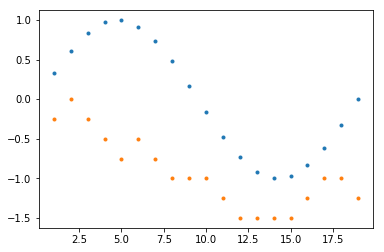

Episode: 29
Reward : -12.0
Average: -8.862068965517242
----------



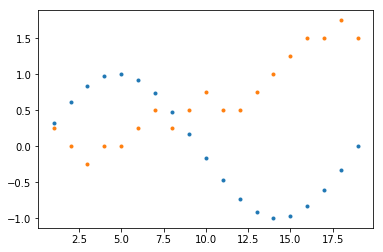

Episode: 43
Reward : -5.0
Average: -8.953488372093023
----------



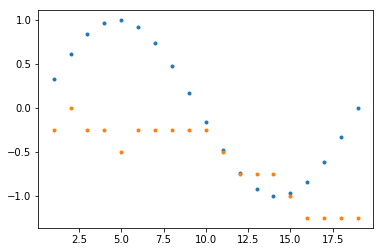

Episode: 57
Reward : -10.0
Average: -8.508771929824562
----------



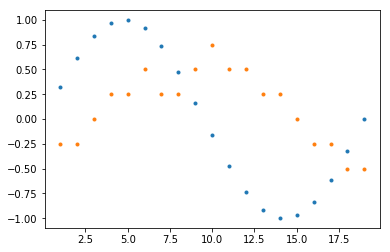

Episode: 71
Reward : -17.0
Average: -7.873239436619718
----------



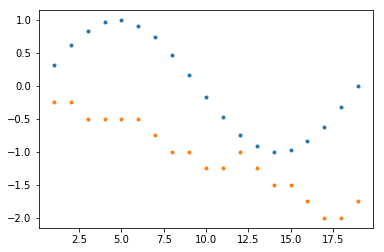

Episode: 85
Reward : -3.0
Average: -7.352941176470588
----------



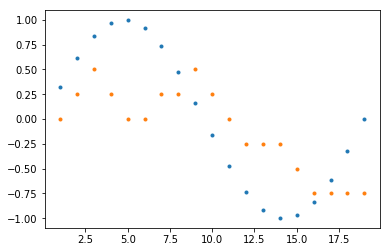

Episode: 99
Reward : 1.0
Average: -6.808080808080808
----------



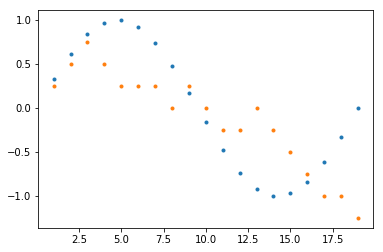

Episode: 114
Reward : -3.0
Average: -5.73
----------



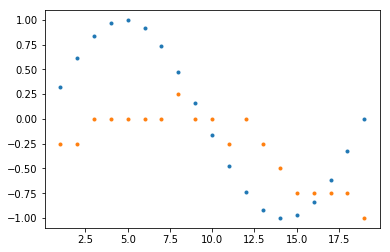

Episode: 128
Reward : -3.0
Average: -5.06
----------



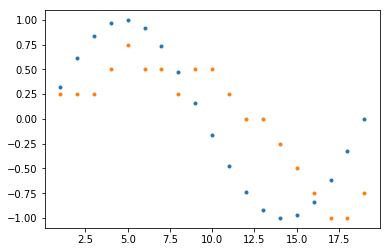

Episode: 142
Reward : -3.0
Average: -3.79
----------



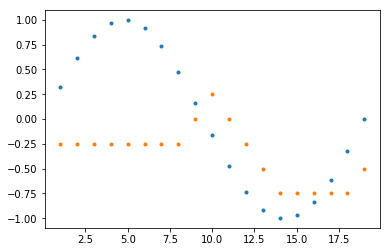

Episode: 156
Reward : 2.0
Average: -2.58
----------



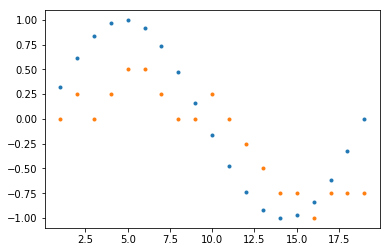

Episode: 170
Reward : 4.0
Average: -1.67
----------



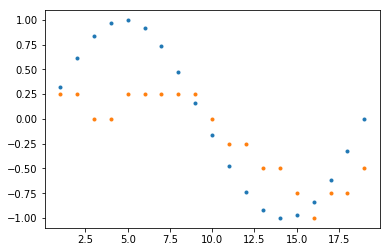

Episode: 184
Reward : 8.0
Average: -0.24
----------



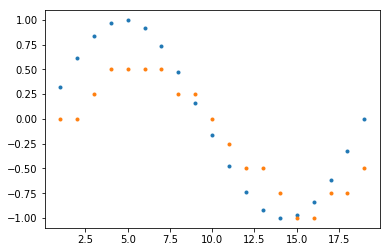

Episode: 198
Reward : 10.0
Average: 0.96
----------



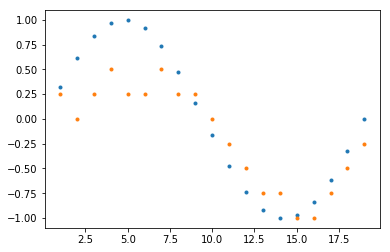

Episode: 213
Reward : 6.0
Average: 2.3
----------



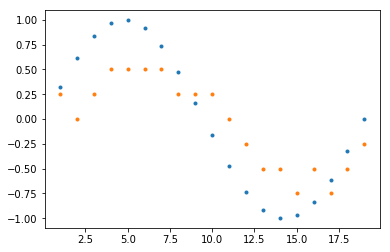

Episode: 227
Reward : 6.0
Average: 3.62
----------



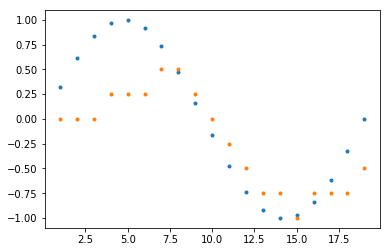

Episode: 241
Reward : 7.0
Average: 4.74
----------



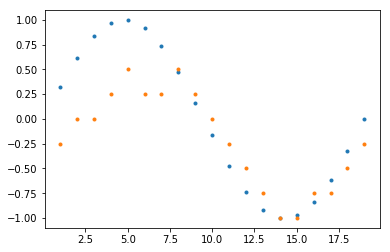

Episode: 255
Reward : 6.0
Average: 5.65
----------



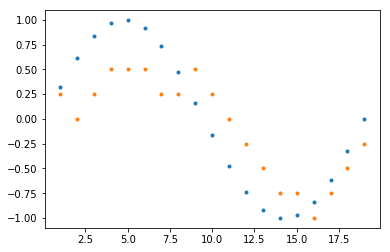

Episode: 269
Reward : 12.0
Average: 6.67
----------



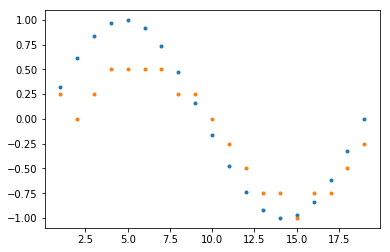

Episode: 283
Reward : 7.0
Average: 7.44
----------



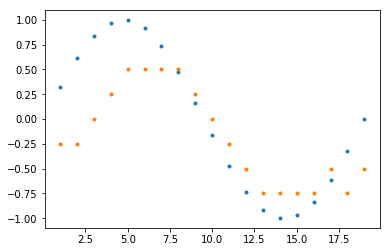

Episode: 297
Reward : 8.0
Average: 8.37
----------



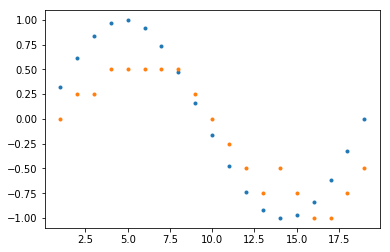

Episode: 312
Reward : 12.0
Average: 9.11
----------



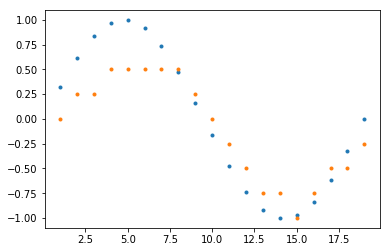

Episode: 326
Reward : 12.0
Average: 9.7
----------



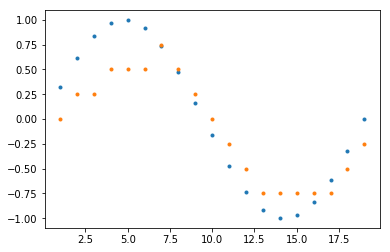

Episode: 340
Reward : 8.0
Average: 10.3
----------



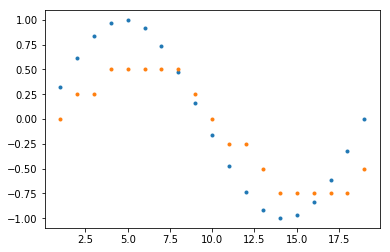

Episode: 354
Reward : 10.0
Average: 10.87
----------



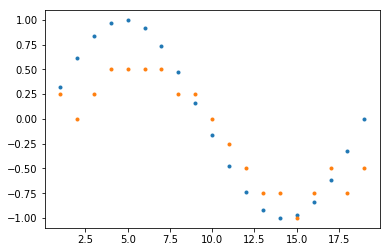

Episode: 368
Reward : 12.0
Average: 11.52
----------



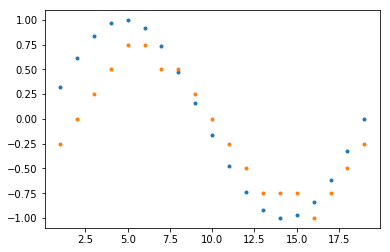

Episode: 382
Reward : 13.0
Average: 11.98
----------



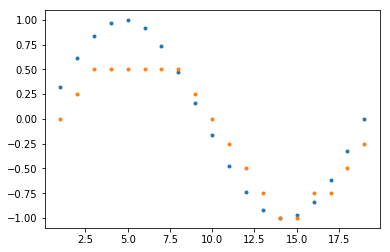

Episode: 396
Reward : 15.0
Average: 12.41
----------



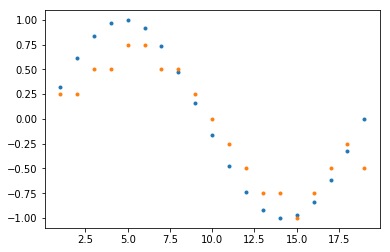

Episode: 411
Reward : 13.0
Average: 12.8
----------



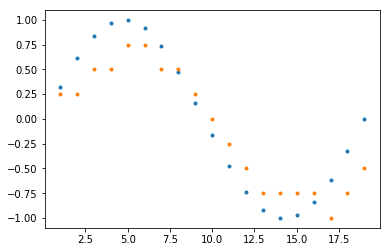

Episode: 425
Reward : 13.0
Average: 13.2
----------



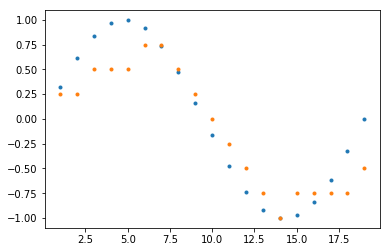

Episode: 439
Reward : 16.0
Average: 13.52
----------



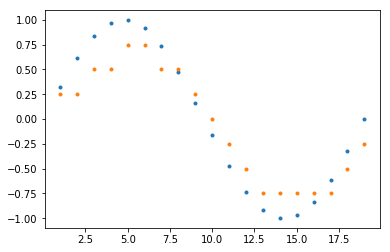

Episode: 453
Reward : 17.0
Average: 13.87
----------



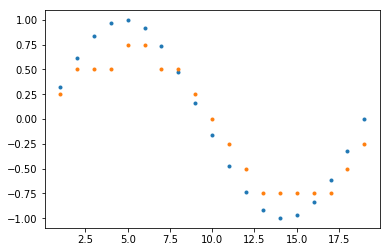

Episode: 467
Reward : 11.0
Average: 14.01
----------



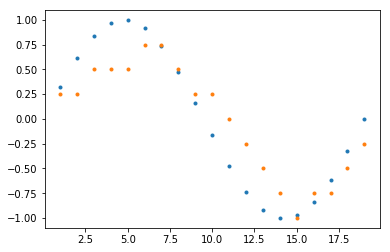

Episode: 481
Reward : 16.0
Average: 14.24
----------



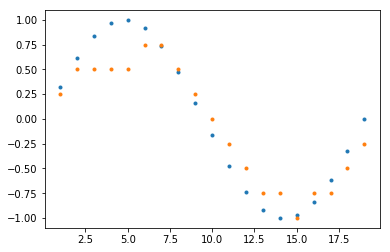

Episode: 495
Reward : 16.0
Average: 14.44
----------



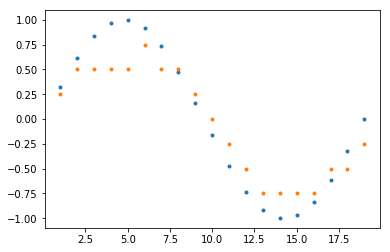

Episode: 510
Reward : 15.0
Average: 14.69
----------



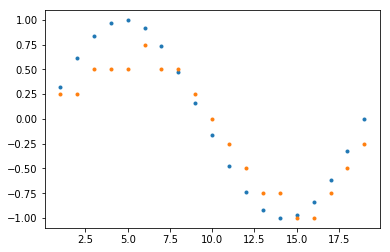

Episode: 524
Reward : 18.0
Average: 14.87
----------



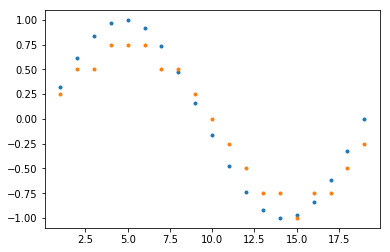

Episode: 538
Reward : 17.0
Average: 15.13
----------



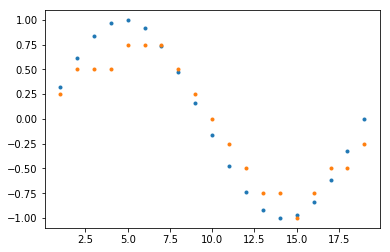

Episode: 552
Reward : 16.0
Average: 15.33
----------



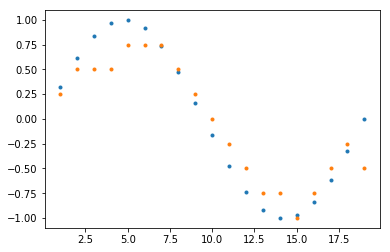

Episode: 566
Reward : 17.0
Average: 15.63
----------



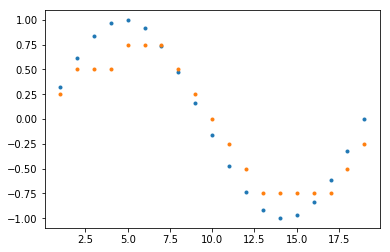

Episode: 580
Reward : 18.0
Average: 15.95
----------



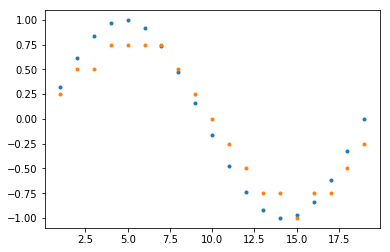

Episode: 594
Reward : 17.0
Average: 16.11
----------



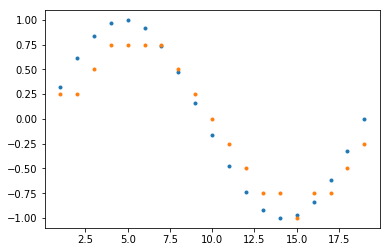

Episode: 609
Reward : 18.0
Average: 16.3
----------



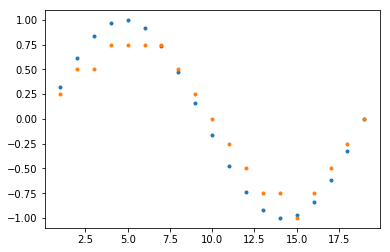

Episode: 623
Reward : 18.0
Average: 16.4
----------



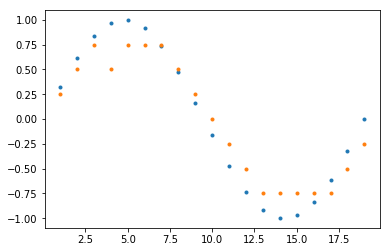

Episode: 637
Reward : 18.0
Average: 16.53
----------



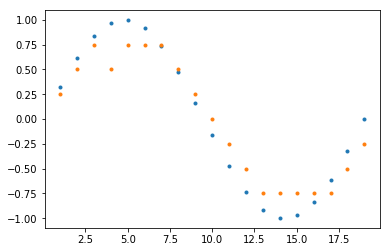

Episode: 651
Reward : 18.0
Average: 16.8
----------



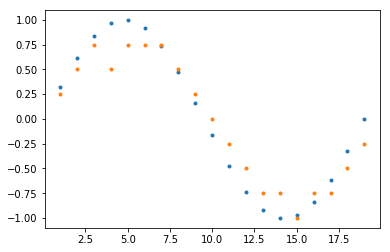

Episode: 665
Reward : 18.0
Average: 16.91
----------



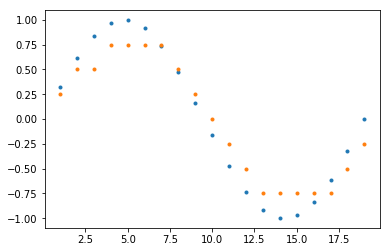

Episode: 679
Reward : 14.0
Average: 16.62
----------



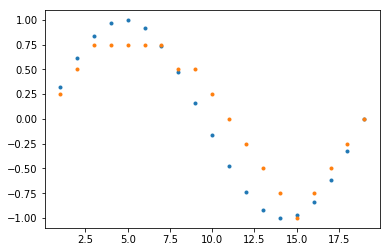

Episode: 693
Reward : 15.0
Average: 16.23
----------



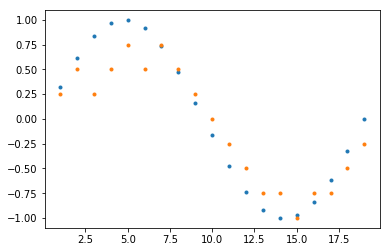

Episode: 708
Reward : 15.0
Average: 15.86
----------



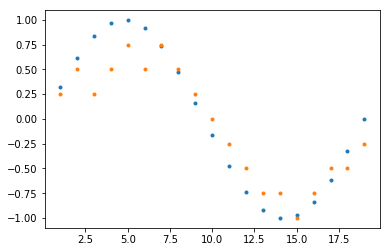

Episode: 722
Reward : 13.0
Average: 15.57
----------



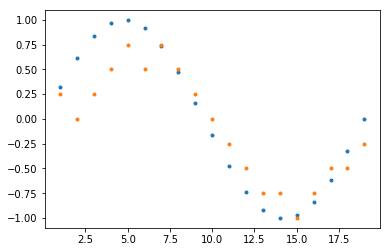

Episode: 736
Reward : 15.0
Average: 15.27
----------



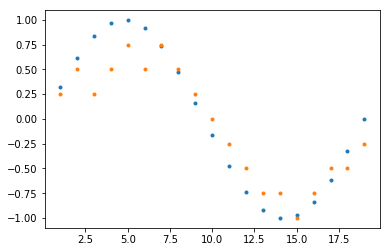

Episode: 750
Reward : 15.0
Average: 14.9
----------



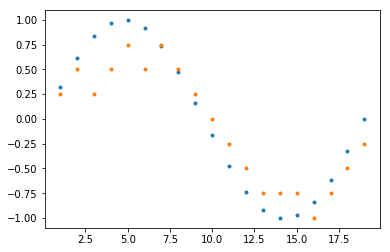

Episode: 764
Reward : 17.0
Average: 14.5
----------



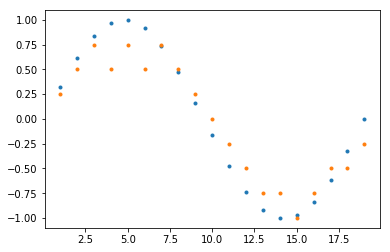

Episode: 778
Reward : 16.0
Average: 14.64
----------



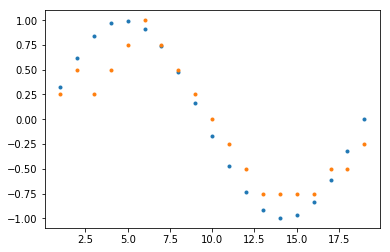

Episode: 792
Reward : 18.0
Average: 15.02
----------



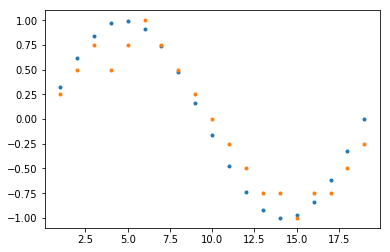

Episode: 807
Reward : 9.0
Average: 15.04
----------



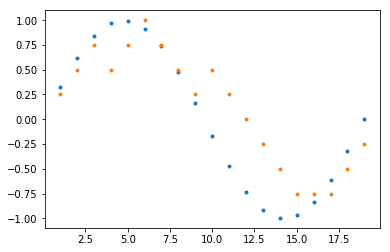

Episode: 821
Reward : 18.0
Average: 15.45
----------



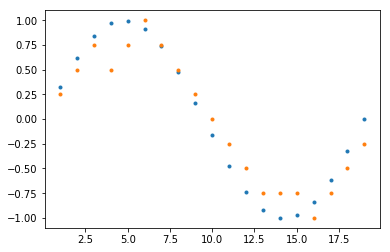

Episode: 835
Reward : 18.0
Average: 15.89
----------



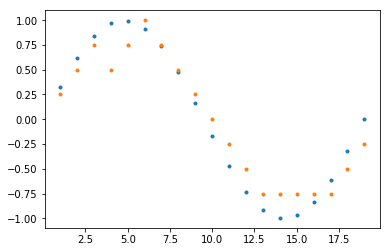

Episode: 849
Reward : 7.0
Average: 15.47
----------



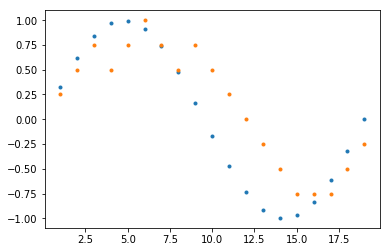

Episode: 863
Reward : 15.0
Average: 15.58
----------



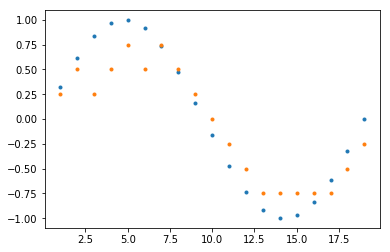

Episode: 877
Reward : 15.0
Average: 15.33
----------



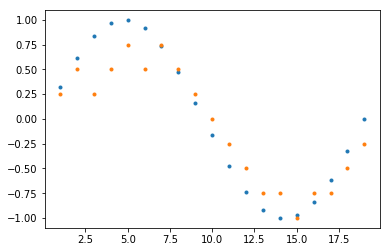

Episode: 891
Reward : 15.0
Average: 15.18
----------



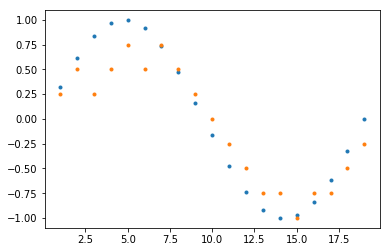

Episode: 906
Reward : 17.0
Average: 15.27
----------



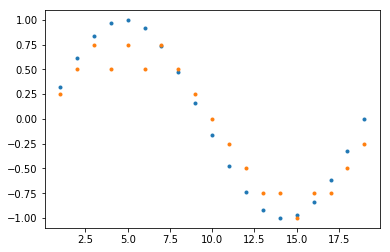

Episode: 920
Reward : 18.0
Average: 15.33
----------



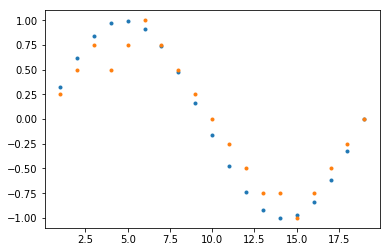

Episode: 934
Reward : 18.0
Average: 15.36
----------



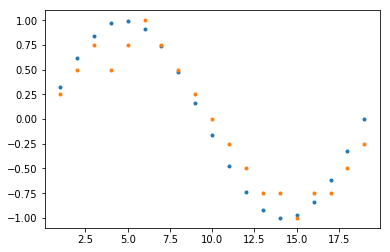

Episode: 948
Reward : 18.0
Average: 16.06
----------



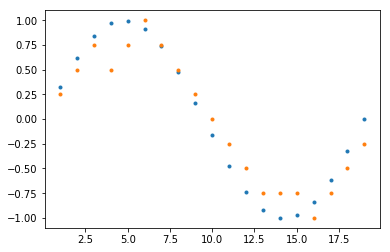

Episode: 962
Reward : 18.0
Average: 16.3
----------



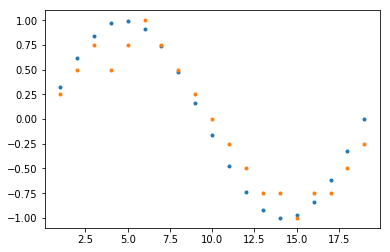

Episode: 976
Reward : 18.0
Average: 16.75
----------



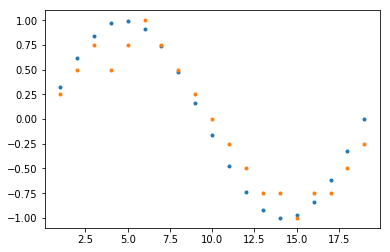

Episode: 990
Reward : 18.0
Average: 17.02
----------



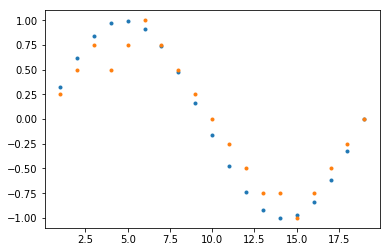

Episode: 1005
Reward : 18.0
Average: 17.42
----------



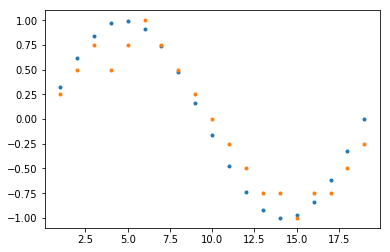

In [9]:
log_interval = 100
buffer_size = 256
batch_size = 64
gamma = 0.99
epochs = 10
train_on_batch = False
episode = 0
episodes = 1001

DUMMY_ACTION, DUMMY_VALUE = np.zeros((1, NUM_ACTS)), np.zeros((1, 1))

observation = env.reset()
reward_history = []

# Collect a batch of samples
while episode < episodes:
    
    batch = {
        'observation': [],
        'action_vector': [],
        'probability': [],
        'reward': []
    }
    
    tmp_batch = {
        'observation': [],
        'action_vector': [],
        'probability': [],
        'reward': []
    }
    
    while len(batch['observation']) < buffer_size:
        action, action_vector, prob = agent.get_action(observation)
        next_observation, reward, done, info = env.step(action)
        
        tmp_batch['observation'].append(observation)
        tmp_batch['action_vector'].append(action_vector)
        tmp_batch['probability'].append(prob)
        tmp_batch['reward'].append(reward)
        
        observation = next_observation

        if done:
            reward_data = np.sum(tmp_batch['reward'])
            reward_history.append(reward_data)
            for j in range(len(tmp_batch['reward']) - 2, -1, -1):
                tmp_batch['reward'][j] += tmp_batch['reward'][j + 1] * gamma
                
            if episode % log_interval != 0:
                # Append Temp Batch to Master Batch
                for i in range(len(tmp_batch['observation'])):
                    obs = tmp_batch['observation'][i]
                    act = tmp_batch['action_vector'][i]
                    prob = tmp_batch['probability'][i]
                    r = tmp_batch['reward'][i]
                    
                    batch['observation'].append(obs)
                    batch['action_vector'].append(act)
                    batch['probability'].append(prob)
                    batch['reward'].append(r)
                    
            if CUSTOM_ENVIRONMENT:
                x_data, target_data, agent_data = env.get_render_data()
                
            observation = env.reset()
            tmp_batch = {
                'observation': [],
                'action_vector': [],
                'probability': [],
                'reward': []
            }
            episode += 1
                
    observations = np.array(batch['observation'])
    actions = np.array(batch['action_vector'])
    probabilities = np.array(batch['probability'])
    rewards = np.array(batch['reward'])    
    rewards = np.reshape(rewards, (len(batch['reward']), 1))
                               
    agent.train_batch(observations, actions, probabilities, rewards)
    
    print('Episode:', episode)
    print('Reward :', reward_data)
    print('Average:', np.mean(reward_history[-log_interval:]))
    print('-'*10)
    print()
    if CUSTOM_ENVIRONMENT:
        plt.plot(x_data, target_data, '.')
        plt.plot(x_data, agent_data, '.')
        plt.show()

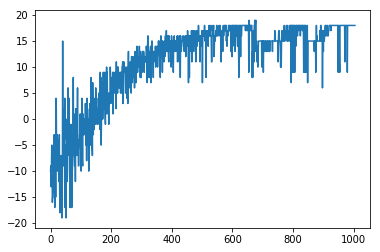

In [10]:
plt.plot(reward_history)
plt.show()